In [1]:
#Installing packages - version control in case and for dependences
# %pip install nltk
# %pip install tensorflow
# %pip install gensim
# %pip install tqdm
# %pip install seaborn
# %pip install pandas
# %pip install scikit-learn

In [2]:
print('hello world')

hello world


In [3]:
#Importing Required libraries
import pandas as pd
import numpy as np
import tensorflow as tf

2025-05-30 03:11:29.634587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748574689.649478   21252 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748574689.653646   21252 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748574689.667591   21252 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748574689.667618   21252 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748574689.667620   21252 computation_placer.cc:177] computation placer alr

Broadly speaking - the architecture of the model is as follows
1. Corpus Embedding
2. Bi-directional LSTM layer
3. Attention Layer
4. Softmax layer to get sentiment

Step 1: Data Pre-Processing

In [4]:
df = pd.read_csv("news_headlines.csv", encoding = "latin-1", header = None).rename(columns = {0: "sentiment", 1: "headline"})
df.head()

,sentiment,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
#Sanity check
df['headline'][1]

'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .'

Let's do some Data Exploration First

In [6]:
#We see that there are only three types of sentiment
df.sentiment.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [7]:
#This means that there are about 4868 headlines
df.shape

(4846, 2)

In [8]:
import nltk 
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
#Use stopwords to improve computational efficiency - as they don't have much semantic revalence
#Just to see what it's like - printed out some to see
stopwords.words('english')[0:5]

['a', 'about', 'above', 'after', 'again']

In [10]:
def clean(corpus):

    #We use set because lookup is O(1) for set
    stopwords_ = set(stopwords.words('english'))
    cleaned_sentence = []

    for sentence in corpus:
        cleaned_words = []
        for words in sentence.split():
            if (words.isalpha()) and (words.lower() not in stopwords_):
                #We use .lower() to make sure the semantic meaning is the same for HAPPY and happy without adding too much context
                cleaned_words.append(words.lower())

        cleaned_sentence.append(' '.join(cleaned_words))

    return cleaned_sentence

In [11]:
df['headline'] = clean(df.headline.values)

In [12]:
df.head(10)

,sentiment,headline
0,neutral,according gran company plans move production r...
1,neutral,technopolis plans develop stages area less squ...
2,negative,international electronic industry company elco...
3,positive,new production plant company would increase ca...
4,positive,according company updated strategy years baswa...
5,positive,financing aspocomp growth aspocomp aggressivel...
6,positive,last quarter componenta net sales doubled peri...
7,positive,third quarter net sales increased eur mn opera...
8,positive,operating profit rose eur mn eur mn correspond...
9,positive,operating profit totalled eur mn eur mn repres...


In [13]:
as_num = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment'] = df['sentiment'].map(as_num)

In [14]:
df.head(5)

,sentiment,headline
0,1,according gran company plans move production r...
1,1,technopolis plans develop stages area less squ...
2,0,international electronic industry company elco...
3,2,new production plant company would increase ca...
4,2,according company updated strategy years baswa...


Now we tokenize the texts (ie turn string into numbers) so the machine can understand and work with it

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
#This V here is a hyperparam to be tuned, but let's use 10000 for now 
vocab_size = 10000
texts = df['headline'].values

tokenizer = Tokenizer(num_words = vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(texts)

In [17]:
#Because these financial texts may not have the same length - we chose to pad them to preserve maximum information to avoid loss in sentiment related tasks
#Although for other tasks where the length is longer it may be preferable to truncate instead of pad
#We transform this into 

max_len = 300
padded = pad_sequences(sequences, maxlen = max_len)

In [18]:
#Because there is no possibility for look ahead bias in texts, we can shuffle the data set via train_test_split
from sklearn.model_selection import train_test_split

X = padded #This is our corpus
y = df.sentiment.values #This is the category/sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)
print(X.shape, y.shape)

(4846, 300) (4846,)


In [19]:
#Now, because we don't want imply any sort of hierarchy -> ie. 2 (positive) is inherently better than 1 (neutral)
from sklearn.preprocessing import OneHotEncoder

ohencoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')

y_train = ohencoder.fit_transform(y_train.reshape(-1, 1))
y_test = ohencoder.fit_transform(y_test.reshape(-1, 1))

print(y_train.shape, y_test.shape)

(3876, 3) (970, 3)


Creating the Embedding Matrix

In [20]:
#Now, because words in Finance may have different semantic meanings than vernacular - we use an Embedding that is good for Finance to generate the Embedding Matrix
#We use a pre-trained Finance Dataset embedding from BankFin Embeddings

# embedding = {}
# with open("bankfinvec_100d.txt", 'r', encoding = "utf8") as file:
#     rows = file.readlines()
#     for row in rows:

#         key = row.split()[0]
#         value = np.asarray(row.split()[1 : ], dtype = 'float32')
#         embedding[key] = value

In [21]:
embedding = {}
with open("glove.6B.200d.txt", 'r', encoding = "utf8") as file:
    rows = file.readlines()
    for row in rows:

        key = row.split()[0]
        value = np.asarray(row.split()[1 : ], dtype = 'float32')
        embedding[key] = value

In [22]:
print(len(embedding['on']))

200


In [23]:
embed_dim = len(embedding['on'])

lookup_table = np.zeros((vocab_size, embed_dim))

for word, idx in word_index.items():
    if idx < vocab_size:
        vector = embedding.get(word)    

        if vector is not None:
            lookup_table[idx] = vector

Model coding and training + hyperparam tuning

LSTM Model 1: Static Word Embeddings From Before
As a refresher, 
Embedding Layer Transforms a matrix of (N, T) -> (N, T, D)
LSTM1 Outputs (N, T, d1)
LSTM2 Outputs (N, d2)
Dense Layer outputs (N, k)


In [24]:
from lstm_tf import LSTM_keras
import tensorflow as tf
# from keras.layers import LSTM, Dense, Embedding, Dropout, Input


In [25]:
tf.__version__

'2.19.0'

In [26]:
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:
# lstm1_dim = 32
# lstm2_dim = 32
# dropout = 0

# embed_layer = Embedding(

#             vocab_size, 
#             embed_dim, 
#             weights = [lookup_table], 
#             input_length = max_len, 
#             trainable = False, 
#             name = "Embed_Layer"
            
#         )

# lstm1 = LSTM(lstm1_dim, return_sequences = True, name = "Layer_1")
# lstm2 = LSTM(lstm2_dim, return_sequences = False, name = "Layer_2")
# dense = Dense(3, activation = 'softmax', name = "Dense")

# input_tensor = Input(shape=(max_len, ), dtype = "int32")

# embdedding_layer = embed_layer(input_tensor)    
# lstm1_out = lstm1(embdedding_layer)
# # lstm1_out = self.dropout(lstm1_out)
# lstm2_out = lstm2(lstm1_out)
# # lstm2_out = self.dropout(lstm2_out)

# output = dense(lstm2_out)

# model = tf.keras.Model(input_tensor, output)
# model.summary()

# METRICS = [
#     #tf.keras.metrics.Accuracy(name='accuracy'),
#     "accuracy",
#     tf.keras.metrics.Precision(name = 'precision'),
#     tf.keras.metrics.Recall(name='recall'),
# ]

# model.compile(optimizer = "adam",
#               loss = "categorical_crossentropy",
#               metrics = METRICS)

# history = model.fit(X_train, 
#                     y_train, 
#                     epochs = 200, 
#                     batch_size = 256, 
#                     # callbacks = callbacks_list,
#                     validation_split = .2)

# lstm1 = LSTM_keras(vocab_size, embed_dim, max_len, lstm1_dim, lstm2_dim, lookup_table, dropout, output_dim = 3)
# lstm1.build(input_shape = (max_len, ))
# lstm1.summary()



In [29]:
lstm1_dim = 32
lstm2_dim = 32
dropout = 0

m1 = LSTM_keras(vocab_size, embed_dim, max_len, lstm1_dim, lstm2_dim, lookup_table, dropout, 3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1748574715.755995   21252 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:26:00.0, compute capability: 8.9


In [30]:
metrics_ = [
    
    "accuracy", 
    tf.keras.metrics.Precision(name = "precision"), 
    tf.keras.metrics.Recall(name = "recall")
    
]

In [31]:
m1.compile(
    
    optimizer = "adam", 
    loss = "categorical_crossentropy", 
    metrics = metrics_
           
)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [33]:

checkpoint_path = "training_1/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.makedirs(checkpoint_dir, exist_ok=True)

callbacks_ = [
    
    EarlyStopping(monitor = "val_accuracy", patience = 10), 
    ModelCheckpoint(filepath = checkpoint_path, monitor = "val_loss", save_best_only = True, save_weights_only = True)
    
]

In [34]:
history = m1.fit(
    
    X_train, 
    y_train, 
    epochs = 10, 
    batch_size = 64, 
    validation_split = 0.2,
    callbacks = callbacks_
    
)

Epoch 1/10


I0000 00:00:1748574718.613638   21382 cuda_dnn.cc:529] Loaded cuDNN version 90300


49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.5774 - loss: 0.9355 - precision: 0.6203 - recall: 0.3139 - val_accuracy: 0.6675 - val_loss: 0.7711 - val_precision: 0.7076 - val_recall: 0.5863
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.6718 - loss: 0.7386 - precision: 0.7283 - recall: 0.5903 - val_accuracy: 0.6959 - val_loss: 0.7181 - val_precision: 0.7373 - val_recall: 0.6186
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.7294 - loss: 0.6508 - precision: 0.7808 - recall: 0.6569 - val_accuracy: 0.6688 - val_loss: 0.7058 - val_precision: 0.7080 - val_recall: 0.6250
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.7601 - loss: 0.5838 - precision: 0.7909 - recall: 0.7101 - val_accuracy: 0.7204 - val_loss: 0.6546 - val_precision: 0.7486 - val_recall: 0.6830
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.8003 - loss: 0.5033 - precision: 0.8226 - recall: 0.7596 - val_accuracy: 0.7255 - val_loss: 0.6739 - val_prec

In [35]:
m1.evaluate(X_test, y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7438 - loss: 0.7257 - precision: 0.7526 - recall: 0.7335


[0.7141355276107788, 0.7494845390319824, 0.75527423620224, 0.7381443381309509]

In [36]:
import matplotlib.pyplot as plt

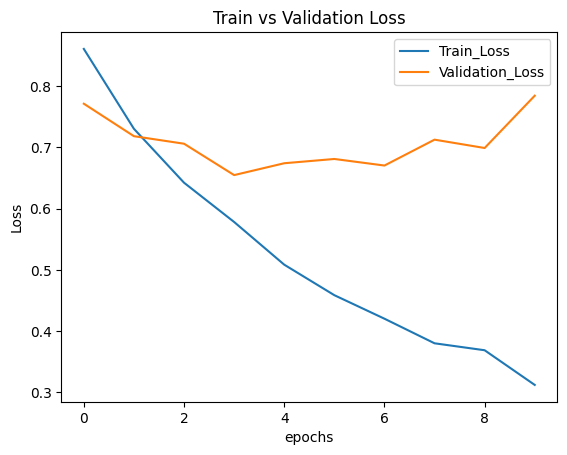

In [37]:
plt.plot(history.history["loss"], label = "Train_Loss")
plt.plot(history.history["val_loss"], label = "Validation_Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

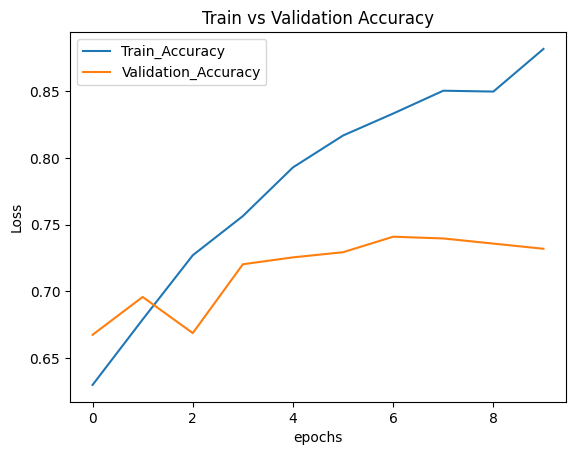

In [38]:
plt.plot(history.history["accuracy"], label = "Train_Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation_Accuracy")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show()

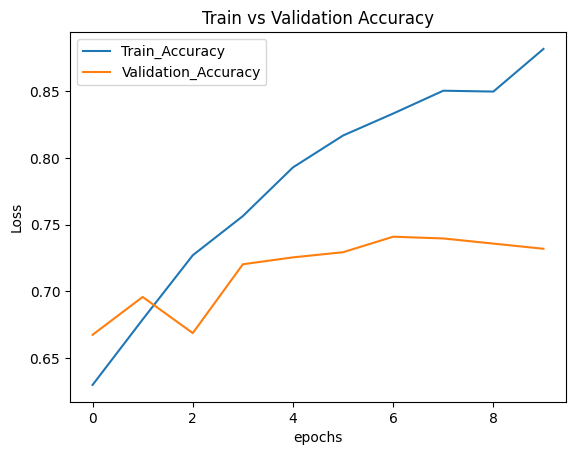

In [39]:
plt.plot(history.history["accuracy"], label = "Train_Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation_Accuracy")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show()

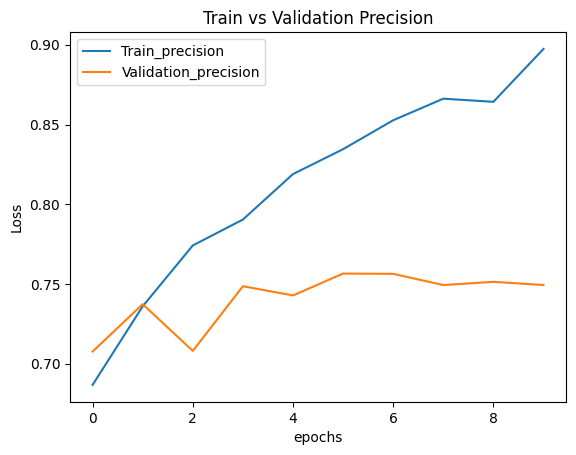

In [40]:
plt.plot(history.history["precision"], label = "Train_precision")
plt.plot(history.history["val_precision"], label = "Validation_precision")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Precision")
plt.legend()
plt.show()

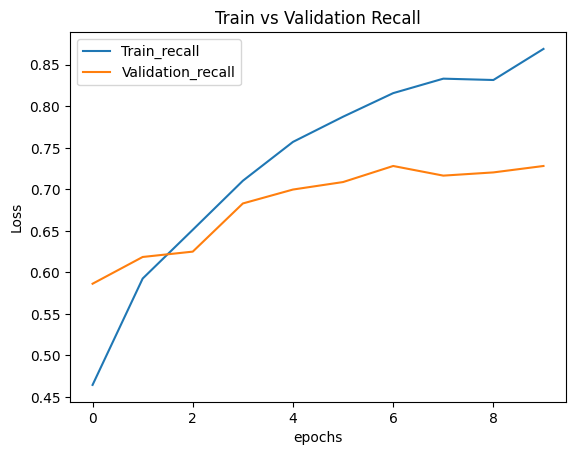

In [41]:
plt.plot(history.history["recall"], label = "Train_recall")
plt.plot(history.history["val_recall"], label = "Validation_recall")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Recall")
plt.legend()
plt.show()

In [42]:
pred = m1.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [43]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

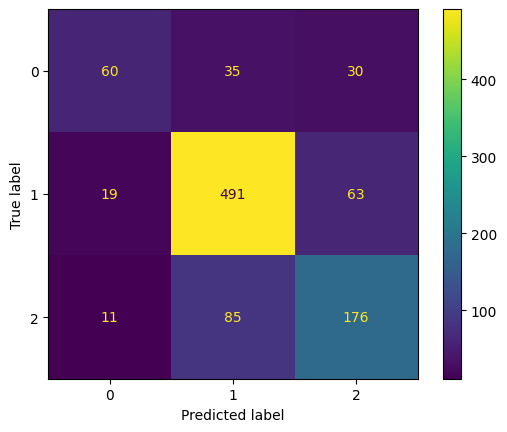

In [44]:
y_pred = np.argmax(pred, axis = 1)
y = np.argmax(y_test, axis = 1)

confusion_matrix_ = confusion_matrix(y, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = [0, 1, 2])
cm_display.plot()
plt.show() 

This is using a static embedding, and only LSTM layer. No hyperparam tuning as well. Let's see what happens if/when we do with a BiDirLSTM + ATTN

In [45]:
from attnbidir_tf import AttnBiDirLSTM

In [46]:
lstm1_dim = 32
lstm2_dim = 32
dropout = 0

m2 = AttnBiDirLSTM(vocab_size, embed_dim, max_len, lstm1_dim, dropout, 3)

In [47]:
attnmetrics_ = [
    
    "accuracy", 
    tf.keras.metrics.Precision(name = "precision"), 
    tf.keras.metrics.Recall(name = "recall")
    
]

In [48]:
m2.compile(
    
    optimizer = "adam", 
    loss = "categorical_crossentropy", 
    metrics = attnmetrics_
           
)

In [49]:
history_ = m2.fit(
    
    X_train, 
    y_train, 
    epochs = 10, 
    batch_size = 64, 
    validation_split = 0.2,
    callbacks = callbacks_
    
)

Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5830 - loss: 0.9507 - precision: 0.6045 - recall: 0.5203 - val_accuracy: 0.5838 - val_loss: 0.9231 - val_precision: 0.5838 - val_recall: 0.5838
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.6106 - loss: 0.8961 - precision: 0.6251 - recall: 0.5986 - val_accuracy: 0.6392 - val_loss: 0.8338 - val_precision: 0.6617 - val_recall: 0.5696
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.7068 - loss: 0.7229 - precision: 0.7556 - recall: 0.6439 - val_accuracy: 0.6624 - val_loss: 0.7866 - val_precision: 0.7127 - val_recall: 0.5657
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.8152 - loss: 0.5002 - precision: 0.8456 - recall: 0.7637 - val_accuracy: 0.6753 - val_loss: 0.8247 - val_precision: 0.6901 - val_recall: 0.6456
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.8985 - loss: 0.3234 - precision: 0.9246 - recall: 0.8733 - val_accuracy: 0.7088 - val_loss: 0.8862 

In [50]:
m2.evaluate(X_test, y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7137 - loss: 1.1717 - precision: 0.7206 - recall: 0.7116


[1.1072381734848022,
 0.7278350591659546,
 0.7345225811004639,
 0.7216494679450989]

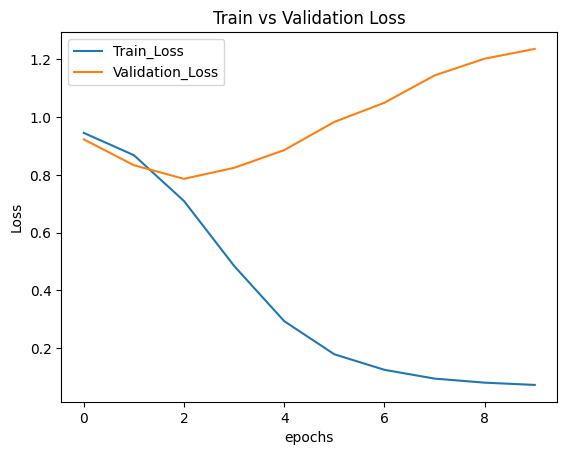

In [51]:
plt.plot(history_.history["loss"], label = "Train_Loss")
plt.plot(history_.history["val_loss"], label = "Validation_Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

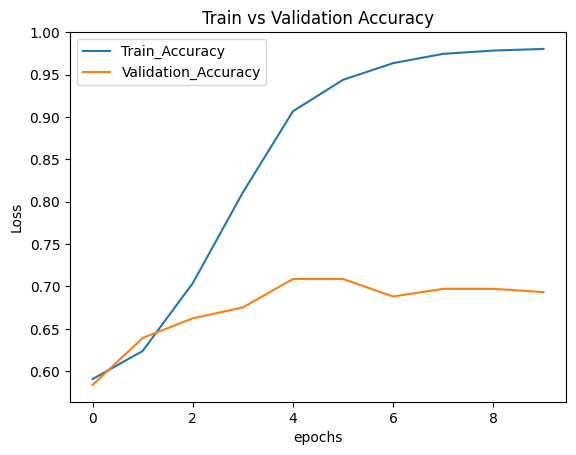

In [52]:
plt.plot(history_.history["accuracy"], label = "Train_Accuracy")
plt.plot(history_.history["val_accuracy"], label = "Validation_Accuracy")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show()

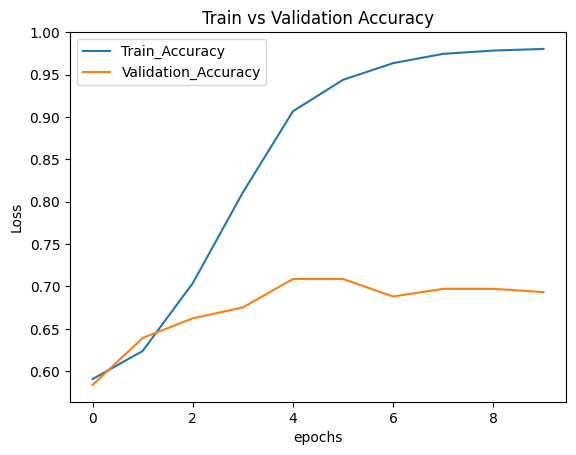

In [53]:
plt.plot(history_.history["accuracy"], label = "Train_Accuracy")
plt.plot(history_.history["val_accuracy"], label = "Validation_Accuracy")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.show()

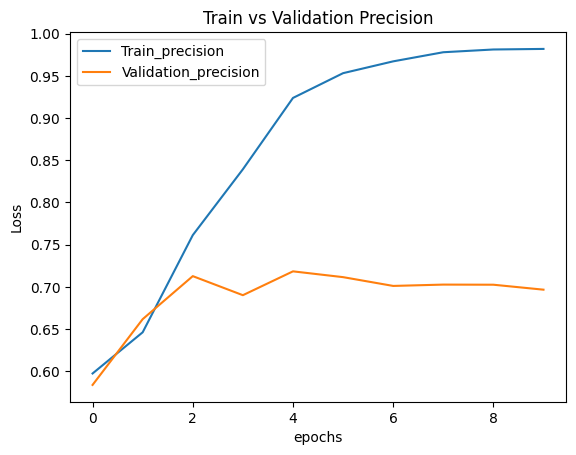

In [54]:
plt.plot(history_.history["precision"], label = "Train_precision")
plt.plot(history_.history["val_precision"], label = "Validation_precision")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Precision")
plt.legend()
plt.show()

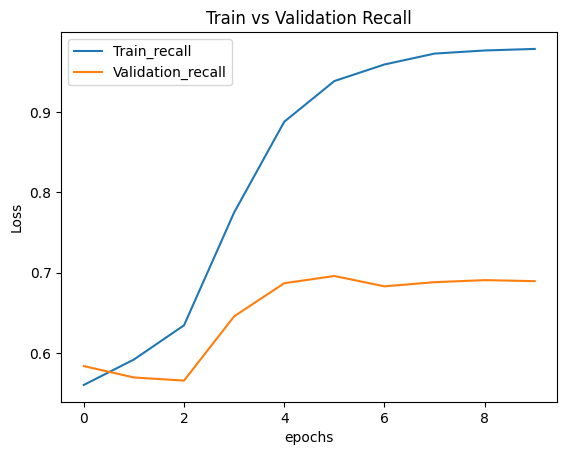

In [55]:
plt.plot(history_.history["recall"], label = "Train_recall")
plt.plot(history_.history["val_recall"], label = "Validation_recall")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Recall")
plt.legend()
plt.show()

In [ ]:
pred_ = m2.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step


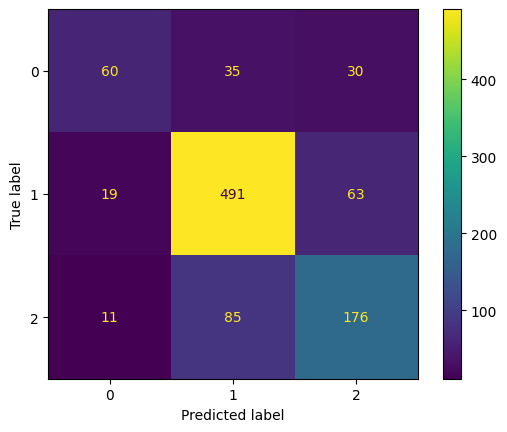

In [79]:
y_pred_ = np.argmax(pred_, axis = 1)
y_ = np.argmax(y_test, axis = 1)

attnconfusion_matrix_ = confusion_matrix(y_, y_pred_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = attnconfusion_matrix_, display_labels = [0, 1, 2])
cm_display.plot()
plt.show() 